# Finding topics in judicial decisions: Topic Modeling on CAP's Illinois data
UC Berkeley, D-Lab CTAWG - March 6th, 2019

Ilya Akdemir 




## Introduction
The goal of this notebook is to give some intuition on the computational text analysis workflow, with a focus on
the two most popular dimensionality-reduction based topic modeling approaches - namely Non-negative Matrix Factorization (NMF) and Latent Dirichlet Allocation (LDA). I apply these models on the novel CAP [case.law](https://case.law/) dataset. Advantages and disadvantages of each algorithm (and dimensionality-reduction based approaches more generally) will be addressed. A key takeaway from this notebook should be that domain knowledge plays an important role at each step of the text analysis workflow.

In [1]:
import lzma
import json
import xml.etree.cElementTree as ET

import pandas as pd
pd.options.display.max_colwidth = 200
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as se
se.set_style('white')
se.set_context('poster')
import pprint
from ipywidgets import FloatProgress

import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition
from gensim.models import LdaModel
from gensim import corpora
import pyLDAvis.gensim

import warnings
warnings.filterwarnings(action='ignore')

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\ProgramData\Anaconda3\lib\site-packages\past\types\oldstr.py:33: DeprecationWarning: invalid escape sequence \d
  """


## Part I - Loading, opening, and parsing the data

In [2]:
# Path of the Illinois file - for those of you who don't have the key yet
path = r'...\path\to\file.xz'

# If you do have the API key you can use it to download the dataset

In [3]:
# a list to hold the sampled cases 
cases = []
max_cases = 10000

In [4]:
# use this function to decompress line by line in range(0, max_cases)
with lzma.open(path) as inline:
    for i, line in enumerate(inline):
        record = json.loads(str(line, 'utf-8'))
        cases.append(record)
        if i == max_cases - 1:
            print("Number of Cases:", len(cases))
            break
  

Number of Cases: 10000


In [5]:
cases[1]    

{'id': 435537,
 'name': 'James A. Whitesides and others, Plaintiffs in Error, v. The People of the State of Illinois, Defendants in Error',
 'name_abbreviation': 'Whitesides v. People',
 'decision_date': '1819-12',
 'docket_number': '',
 'first_page': '21',
 'last_page': '22',
 'citations': [{'type': 'official', 'cite': '1 Ill. 21'}],
 'volume': {'volume_number': '1'},
 'reporter': {'full_name': 'Illinois Reports'},
 'court': {'id': 8853,
  'name': 'Illinois Supreme Court',
  'name_abbreviation': 'Ill.',
  'jurisdiction_url': None,
  'slug': 'ill-1'},
 'jurisdiction': {'id': 29,
  'slug': 'ill',
  'name': 'Ill.',
  'name_long': 'Illinois',
  'whitelisted': True},
 'casebody': {'status': 'ok',
  'data': '<?xml version=\'1.0\' encoding=\'utf-8\'?>\n<casebody xmlns="http://nrs.harvard.edu/urn-3:HLS.Libr.US_Case_Law.Schema.Case_Body:v1" xmlns:xlink="http://www.w3.org/1999/xlink" firstpage="21" lastpage="22"> <parties pgmap="21" id="b21-4">James A. Whitesides and others, Plaintiffs in Error

In [6]:
# XML parsing function
def ET_parse_xml(case):
    feat_dict = {}
    header = True
    feat_dict["court"] = case['court']['name']
    feat_dict["date"] = case['decision_date']
    for elem in ET.fromstring(case['casebody']['data']):
        opinions = []
        if elem.tag.split("}")[1] == "opinion":
            op = {}
            text = []
            op["type"] = elem.attrib["type"]
            op["author"] = ""
            for opinion_element in elem.getchildren():
                if opinion_element.tag.split("}")[1] == 'author':
                    op["author"] = opinion_element.text.replace(u'\xad', '')
                else:
                    text.append(opinion_element.text.replace(u'\xad', ''))
            op["text"] = " ".join(text)
            opinions.append(op)
    feat_dict["opinions"] = opinions
    return feat_dict

In [7]:
# Load data into a parsed_files list
bar = FloatProgress(min = 0, max = len(cases))
display(bar)

# For each file, parse with parse_xml() and add to list of parsed files
parsed_files = []
for case in cases:
    doc = ET_parse_xml(case) 
    parsed_files.append(doc)
    bar.value += 1
    

FloatProgress(value=0.0, max=10000.0)

In [8]:
parsed_files[1]

{'court': 'Illinois Supreme Court',
 'date': '1819-12',
 'opinions': [{'type': 'majority',
   'author': '',
   'text': 'Opinion of the Court. This was a criminal prosecution for a riot, against the plaintiffs in error. Three errors are assigned. 1. Uncertainty in the indictment, in not averring the year to be the year of our Lord. 2. The form prescribed by the constitution, in which criminal prosecutions shall be commenced, is not pursued. 3. There is not such a criminal offense alleged in the indictment, as will make the plaintiffs in error guilty of a riot, if committed. On the first point, the law makes it necessary to have common certainty in every indictment, and nothing can be inferred to aid it. Without inference, the year could not be gathered from the indictment, and therefore it is defective. On the second point, when a constitution or act of the legislature, prescribes a certain form to be used in legal proceedings, it would seem that the court has no power to dispense with 

In [9]:
# Create a pandas dataframe to visualize our dataset
raw_df = pd.DataFrame(parsed_files)

# Parse dates
raw_df["date"] = pd.to_datetime(raw_df["date"])

# Strip out some sparse early data
df = raw_df[raw_df["date"] >= '1820-01-01']

In [10]:
# The sample is from 1820 to 1875 - an interesting period in American history due to civil war/industrialization
df.tail()

,court,date,opinions
9995,Illinois Supreme Court,1875-09-01,"[{'type': 'majority', 'author': 'Mr. Justice B re ese', 'text': 'delivered the opinion of the Court: The questions raised on this record arise out of the following facts: John Watt commenced an ac..."
9996,Illinois Supreme Court,1875-09-01,"[{'type': 'majority', 'author': 'Mr. Justice Craig', 'text': 'delivered the opinion of the Court: This was a bill in equity, exhibited in the Superior Court of Cook county by Henry L. Gunnell and ..."
9997,Illinois Supreme Court,1875-09-01,"[{'type': 'majority', 'author': 'Mr. Justice Craig-', 'text': 'delivered the opinion of the Court: This was an action of trespass on the case, brought by appellee against The Chicago and Northwest..."
9998,Illinois Supreme Court,1875-09-01,"[{'type': 'majority', 'author': 'Mr. Chief Justice Scott', 'text': 'delivered the opinion of the Court: The fact the bill may not have been signed either by complainant or counsel, can not be insi..."
9999,Illinois Supreme Court,1875-09-01,"[{'type': 'majority', 'author': 'Mr. Justice Sheldon', 'text': 'delivered the opinion of the Court: This was an action brought to recover for damages resulting to the plaintiff by reason of the ne..."


In [11]:
# Takes a dataframe of cases and an n-gram and returns a list of (year, n-gram count) tuples
def get_ngram_count(cases, ngram):
    
    #Build a dictionary of all years present in the dataframe
    result = {year:0 for year in cases["date"].apply(lambda x: x.year).unique()}
    #Across all cases...
    for _, case in cases.iterrows():
        mentions = 0
        for opinion in case['opinions']:
            #...count all cases containing n-gram using dictionary entries
            if (ngram in opinion['text'].lower()):
                result[int(case['date'].year)] += 1
                break
    #Return a sorted list of the tuples
    return sorted(list(result.items()), key=lambda x:x[0])

# Visualize an ngram using matplotlib, passing in an axis
def visualize_ngram(title, ax, ngram_data):
    # Get counts of each year across case decision dates (we use to this to calculate proportion of cases with n-gram)
    year_counts = df["date"].apply(lambda x:x.year).value_counts().sort_index().values
    ax.set_xlim(1819,1876)
    ax.set_title("'{}' occurs in {} cases".format(title, sum(x[1] for x in ngram_data)))
    ax.set_ylabel("Proportion of cases with ngram")
    ax.set_xlabel("Year Decided")
    # Years on the x-axis, n-gram counts on the y axis
    ax.plot([x[0] for x in ngram_data], [x[1] for x in ngram_data]/year_counts)

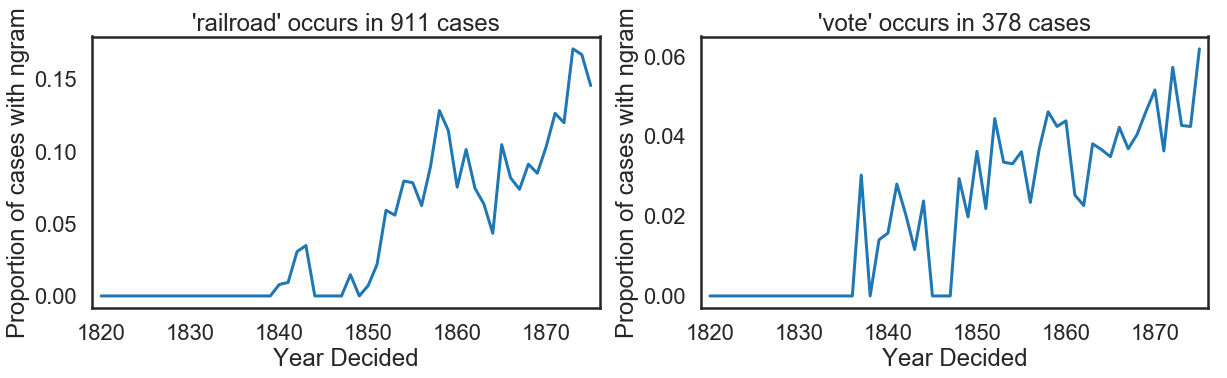

In [12]:
# Generate subplots
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(20, 5))

# generate visualizations for n-grams, passing a matplotlib axis for each
ngrams_of_interest = ['railroad', 'vote']
                      
visualize_ngram(ngrams_of_interest[0], axes[0], get_ngram_count(df, ngrams_of_interest[0]))
visualize_ngram(ngrams_of_interest[1], axes[1], get_ngram_count(df, ngrams_of_interest[1]))

## Part II - Text Cleaning 


In [13]:
df.opinions.iloc[0]

[{'type': 'majority',
  'author': '',
  'text': "Opinion of the Court. It is necessary by the common law, to make profert of writings under seal, so as to place them in the power of the court, to give 'the opposite party oyer if required, and to let the court see if the deed is fair and honest on view. From the statute, it is necessary for the party to have oyer of writings not under seal, on which suit is brought, as he is bound to deny the execution of them, under the plea of non est factum, under oath. A copy of the writing on which suit is brought, must be filed with the declaration, and the court can, upon a plea of oyer, compel the production of the original, so that no inconvenience can arise from the want of proferí. There is no error then, on this point.  As to the second point, the court believe it is never necessary to state a consideration in a case on an assigned note, between the maker and the assignee. The judgment of the court below is affirmed,  Judgment affirmed.     

In [14]:
df['text'] = df['opinions'].astype(str)

sep = r"text\': "
df['text'] = df['text'].str.split(sep, 1).str[-1].str.strip()

In [15]:
# Stopwords
stop_words = set(stopwords.words('English'))

In [16]:
# define cleaning function
def clean_text(text): 
    # remove numbers
    text = text.apply(lambda x: ''.join([i for i in x if not i.isdigit()]))
    # remove punctuation
    text = text.str.replace(r'[^\w\s]', r' ')
    # lowercase
    text = text.str.lower()
    # remove stopwords
    text = text.str.split(' ').apply(lambda x: ' '.join(k for k in x if k not in stop_words))
    
    return text

In [17]:
# define Wordnet Lemmatizer/Tokenizer Function which removes plurals and possessives 
tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()         #although, compare "damages" to "damage"

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in tokenizer.tokenize(text)]

In [18]:
# Apply the cleaning function
df['cleaned'] = clean_text(df['text'])

In [19]:
# tokenize, lemmatize and detokenize to remove plurals/whitespace
df['cleaned'] = df.cleaned.apply(lemmatize_text)

In [20]:
# Detokenize to convert to a string remove all white space and new lines
df['cleaned'] = df['cleaned'].apply(lambda x: ','.join(map(str, x)))
df['cleaned'] = df['cleaned'].replace({',': ' '}, regex=True)

## Part III - Topic modeling: Non-negative matrix factorization (NFM)

In [21]:
# export documents to a list
raw_documents = df.cleaned.tolist()

In [22]:
# Create a TFIDF vectorizer - one of the main advantages of NMF is that it can utilize TFIDF 
vectorizer = TfidfVectorizer(min_df = 2) 

In [23]:
# Create Matrix A using vectorizer
A = vectorizer.fit_transform(raw_documents)
print( "Dimensions of TF-IDF matrix are: %d x %d" % (A.shape[0], A.shape[1]))

Dimensions of TF-IDF matrix are: 9994 x 22962


In [24]:
# get terms/features in our new matrix
features = vectorizer.get_feature_names()
print("Number of terms:", (len(features)))

Number of terms: 22962


In [25]:
# define number of topics
k = 40

# How many descriptor words 
top_words = 10

In [26]:
# create NMF model
model = decomposition.NMF(init = "nndsvd", 
                          n_components = k ) 

In [27]:
# apply the model and extract the two W and H matrices -> A = W*H 
W = model.fit_transform(A)
H = model.components_

print("Dimensions of Document-topic matrix W are:", W.shape) 
print("Dimensions of Topic-term matrix H are:", H.shape)

Dimensions of Document-topic matrix W are: (9994, 40)
Dimensions of Topic-term matrix H are: (40, 22962)


In [28]:
# Define get_descriptor function which will show top words for a given topic
def get_descriptor( features, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( features[term_index] )
    return top_terms

In [29]:
# show topics and words in those topics
descriptors = []
for topic_index in range( k ):
    descriptors.append( get_descriptor( features, H, topic_index, top_words) )  # Top 10 words
    str_descriptor = ", ".join( descriptors[topic_index] )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: jury, evidence, instruction, verdict, witness, trial, testimony, court, given, fact
Topic 02: deed, title, trust, conveyance, covenant, grantor, executed, grantee, certificate, recorded
Topic 03: act, law, section, shall, state, power, legislature, constitution, provision, statute
Topic 04: company, policy, insurance, stock, railroad, corporation, agent, fire, charter, loss
Topic 05: note, maker, payee, promissory, consideration, payable, due, maturity, assignee, instrument
Topic 06: plaintiff, defendant, said, action, error, recover, suit, judgment, horse, brought
Topic 07: decree, bill, complainant, answer, court, equity, defendant, chancery, injunction, relief
Topic 08: contract, work, agreement, party, building, lien, performance, material, appellees, time
Topic 09: property, execution, sheriff, levy, creditor, attachment, levied, lien, officer, judgment
Topic 10: appellee, appellant, evidence, appellees, pay, recover, paid, appears, would, court
Topic 11: tax, collector,

## Part IV - Topic modeling: Latent Dirichlet Allocation (LDA)

In [30]:
# Just like with NFM, the main parameter of these unsupervised techniques is number of topics "k"
k = 40

# Again, how many words we want to see
top_words = 10

In [31]:
# Let's retokenize our words
df['cleaned'] = df.cleaned.apply(lemmatize_text)

In [32]:
# create dictionary which maps words to id's
dictionary = corpora.Dictionary(df.cleaned)

In [33]:
# Converts to bag of words - how many times a given term appears in a document
lda_corpus = [dictionary.doc2bow(doc) for doc in df.cleaned]

In [34]:
# build LDA model
lda_model = LdaModel(lda_corpus, 
                     num_topics = k, 
                     id2word = dictionary)
                    # seed = 10)

In [35]:
# Show the topics
topics = lda_model.show_topics(formatted = False,  
                               num_topics = -1,
                            num_words = top_words)

for t in range(len(topics)):
    print("Topic {}, top {} words:".format( t+1, top_words))
    print(", ".join([w[0] for w in topics[t][1]])) 

Topic 1, top 10 words:
court, judgment, record, error, upon, award, said, party, cause, case
Topic 2, top 10 words:
stock, act, county, state, tax, property, law, power, corporation, made
Topic 3, top 10 words:
company, policy, insurance, upon, case, made, evidence, agent, v, stock
Topic 4, top 10 words:
draft, case, court, evidence, would, upon, one, letter, agent, money
Topic 5, top 10 words:
law, court, case, plaintiff, evidence, defendant, act, upon, would, v
Topic 6, top 10 words:
appellee, appellant, car, would, money, case, bank, court, time, grain
Topic 7, top 10 words:
plaintiff, defendant, court, judgment, plea, evidence, said, action, upon, case
Topic 8, top 10 words:
note, said, bond, court, appellant, pay, time, money, payment, upon
Topic 9, top 10 words:
county, city, law, act, court, shall, election, town, board, section
Topic 10, top 10 words:
good, case, carrier, would, company, said, defendant, state, railroad, plaintiff
Topic 11, top 10 words:
estate, executor, case,

In [36]:
# Create interactive pyLDAvis visualization
lda_display = pyLDAvis.gensim.prepare(lda_model, 
                                      lda_corpus, 
                                      dictionary, 
                                      sort_topics = False)
pyLDAvis.display(lda_display)

pyLDAvis.save_html(lda_display, 'lda_visualization.html')
# See lda_visualization.html to explore the LDA based topics

In [37]:
# To see associated weights for words in topics
pp = pprint.PrettyPrinter(indent = 3)
pp.pprint(lda_model.print_topics(num_words = top_words))

[  (  29,
      '0.019*"walker" + 0.016*"covenant" + 0.012*"deed" + 0.010*"estate" + '
      '0.010*"case" + 0.008*"delivery" + 0.008*"guardian" + 0.007*"time" + '
      '0.007*"whitman" + 0.007*"said"'),
   (  35,
      '0.029*"tax" + 0.018*"property" + 0.013*"land" + 0.013*"homestead" + '
      '0.011*"upon" + 0.011*"judgment" + 0.011*"case" + 0.010*"court" + '
      '0.009*"law" + 0.007*"deed"'),
   (  22,
      '0.028*"land" + 0.013*"line" + 0.009*"east" + 0.009*"north" + '
      '0.008*"west" + 0.008*"south" + 0.008*"quarter" + 0.008*"section" + '
      '0.007*"one" + 0.007*"upon"'),
   (  39,
      '0.017*"road" + 0.012*"act" + 0.012*"public" + 0.011*"city" + '
      '0.010*"court" + 0.010*"company" + 0.008*"street" + 0.008*"right" + '
      '0.008*"railroad" + 0.008*"upon"'),
   (  8,
      '0.019*"county" + 0.015*"city" + 0.014*"law" + 0.012*"act" + '
      '0.012*"court" + 0.011*"shall" + 0.009*"election" + 0.009*"town" + '
      '0.008*"board" + 0.008*"section"'),
   (  13,
 

## Part V - Discussion

It seems that NMF based approach gives more coherent topics than LDA, at least based on a subjective reading of the generated topics and associated words (although, some LDA topics are pretty good too). There is literature suggesting that NMF seems to be able to identify niche topics in non-mainstream areas. Nevertheless, there are conflicting accounts with respect to the quality of the output that both algorithms produce.

The key practical distinction is the document-term matrix that is used as input - NMF can take TF-IDF weighted DTM, whereas LDA is limited to a an unweighted DTM. Furthermore, finding the right <em>k</em> is of fundamental importance, as the individual words that contribute to a given topic can change based on the choice of <em>k</em>. 

## Acknowledgements 

In addition to my own code, this notebook utilizes some (modified) code and insights from the following repositories:

1) CAP's example code notebooks for the case.law dataset ->  https://github.com/harvard-lil/cap-examples

2) Professor Derek Greene; NMF topic modeling tutorial -> https://github.com/derekgreene/topic-model-tutorial

3) Geoffrey Boushey and Aaron Culich - the work done during the TextXD 2018 collaborative hackathon was especially useful in exploring and understanding the .jsonl data structure of the text in the dataset -> https://github.com/gboushey/TextXD-CaseLaw